#Memasukan Data dan Menampilkan Data

In [2]:
import pandas as pd


data = 'dataset.csv'
df = pd.read_csv(data)
print(df)

        game_id  club_id  own_goals  own_position      own_manager_name  \
0       2320450     1468          0           NaN     Holger Bachthaler   
1       2320460        1          3           NaN       Jürgen Luginger   
2       2320472     2036          4           NaN         Frank Schmidt   
3       2321044       16          2           1.0          Jürgen Klopp   
4       2321060       23          0          18.0  Torsten Lieberknecht   
...         ...      ...        ...           ...                   ...   
143369  3912732      602          0           NaN     Vladimir Cheburin   
143370  3912739      540          0           NaN        Vladimír Weiss   
143371  4031421     2156          0           NaN       José Luis Oltra   
143372  4138038      317          1           NaN        Joseph Oosting   
143373  4188444     1132          4           NaN       Vincent Kompany   

        opponent_id  opponent_goals  opponent_position opponent_manager_name  \
0                24

#Standarisasi dan Cleaning

In [7]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when
from pyspark.sql.types import IntegerType, StringType

spark = SparkSession.builder.appName("DataCleaning").getOrCreate()
file_path = "dataset.csv"
df = spark.read.csv(file_path, header=True, inferSchema=True)

# Perbaiki masalah penulisan pada dataset
df = df.withColumn("own_manager_name", when(col("own_manager_name").contains("JÃ¼rgen"), "Jürgen Luginger")
                                      .otherwise(col("own_manager_name"))) \
       .withColumn("opponent_manager_name", when(col("opponent_manager_name").contains("JÃ¼rgen"), "Jürgen Klopp")
                                              .otherwise(col("opponent_manager_name"))) \
       .withColumn("opponent_manager_name", when(col("opponent_manager_name").contains("José"), "José Gomes")
                                              .otherwise(col("opponent_manager_name")))

# Gantilah nilai NaN/None pada kolom numerik dengan nilai  0
df = df.fillna({"own_goals": 0, "own_position": 0, "opponent_goals": 0, "opponent_position": 0})

# Konversikan kolom numerik menjadi tipe integer
df = df.withColumn("own_goals", col("own_goals").cast(IntegerType())) \
       .withColumn("own_position", col("own_position").cast(IntegerType())) \
       .withColumn("opponent_goals", col("opponent_goals").cast(IntegerType())) \
       .withColumn("opponent_position", col("opponent_position").cast(IntegerType())) \
       .withColumn("is_win", col("is_win").cast(IntegerType()))

# Memeriksa apakah ada penduplikatan
df = df.dropDuplicates()

# menampilkan hasilnya
df.show()



+-------+-------+---------+------------+--------------------+-----------+--------------+-----------------+---------------------+-------+------+
|game_id|club_id|own_goals|own_position|    own_manager_name|opponent_id|opponent_goals|opponent_position|opponent_manager_name|hosting|is_win|
+-------+-------+---------+------------+--------------------+-----------+--------------+-----------------+---------------------+-------+------+
|2635619|   2439|        1|           0|      Sergey Tashuev|        232|             0|                0|    Dmitriy Alenichev|   Home|     1|
|2877342|   1090|        0|           3|   John van den Brom|       1426|             0|               10|       Maurice Steijn|   Home|     0|
|2921409|   2700|        0|          15|   Vadim Skripchenko|        932|             1|                1|          Yuriy Semin|   Home|     0|
|2626461|   7185|        1|          16|Dimitrios Elefthe...|       2672|             3|                5|   Apostolos Mantzios|   Home|

#Filterasi Berdasarkan Jumlah Gol Tim Mikel Arteta

In [9]:
import plotly.express as px
import pandas as pd
import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

spark = SparkSession.builder.appName("DataVisualization").getOrCreate()

df_arteta = df.filter(df["own_manager_name"] == "Mikel Arteta")

df_arteta_pd = df_arteta.toPandas()

# Mengambil sample 38 pertandingan pertama
df_arteta_pd = df_arteta_pd.head(38)

# Membuat data untuk visualisasi
df_arteta_pd['match_number'] = np.arange(1, len(df_arteta_pd) + 1)

# Visualisasi menggunakan Plotly
fig = px.line(
    df_arteta_pd,
    x='match_number',
    y=['own_goals', 'opponent_goals'],
    labels={'own_goals': 'Gol Mikel Arteta', 'opponent_goals': 'Gol Lawan'},
    title='Jumlah Gol Mikel Arteta vs Lawan Setiap Pertandingan (38 Pertandingan Pertama)',
    line_shape='linear',
)

# Update layout
fig.update_layout(
    title_font=dict(size=20, color='darkblue'),
    xaxis=dict(
        title='Pertandingan',
        tickmode='array',
        tickvals=np.arange(1, 39),
        ticktext=[f'Pertandingan {i}' for i in range(1, 39)],
        tickangle=45,
    ),
    yaxis=dict(title='Jumlah Gol'),
    plot_bgcolor='white',
    font=dict(size=12),
)

fig.show()


#Menyiapkan Feauture menggunakan Vector Assemble

In [71]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

spark = SparkSession.builder.appName("ArtetaWinPrediction").getOrCreate()

# Memastikan kolom memiliki tipe data yang sesuai
df = df.withColumn("own_goals", col("own_goals").cast("int")) \
       .withColumn("own_position", col("own_position").cast("int")) \
       .withColumn("opponent_goals", col("opponent_goals").cast("int")) \
       .withColumn("opponent_position", col("opponent_position").cast("int")) \
       .withColumn("is_win", col("is_win").cast("int"))

# Memastikan urutan
df = df.select("game_id", "own_goals", "own_position", "opponent_goals", "opponent_position", "is_win")

# Menyiapkan fitur menggunakan VectorAssembler
assembler = VectorAssembler(
    inputCols=["own_goals", "own_position", "opponent_goals", "opponent_position"],
    outputCol="features"
)

df_assembled = assembler.transform(df)

#Membagi Data dan Melakukan Prediksi

In [73]:
# Membagi data (80% training, 20% testing)
train_data, test_data = df_assembled.randomSplit([0.8, 0.2], seed=1234)

# Melatih model Logistic Regression
lr = LogisticRegression(featuresCol="features", labelCol="is_win")

# Melatih model dengan data training
lr_model = lr.fit(train_data)

# Melakukan prediksi pada data testing
predictions = lr_model.transform(test_data)

# Menampilkan hasil prediksi 38 pertandingan
predictions.select("game_id", "is_win", "prediction").show(38)

+-------+------+----------+
|game_id|is_win|prediction|
+-------+------+----------+
|2218677|     0|       0.0|
|2219795|     0|       0.0|
|2221756|     0|       0.0|
|2221758|     1|       1.0|
|2221759|     0|       0.0|
|2221760|     0|       0.0|
|2221761|     0|       0.0|
|2221767|     1|       1.0|
|2221772|     1|       1.0|
|2221773|     1|       1.0|
|2222360|     1|       1.0|
|2222537|     0|       0.0|
|2222537|     1|       1.0|
|2222538|     0|       0.0|
|2222541|     1|       1.0|
|2222586|     0|       0.0|
|2222589|     1|       1.0|
|2222590|     1|       1.0|
|2222593|     0|       0.0|
|2222598|     0|       0.0|
|2222600|     1|       1.0|
|2222602|     0|       0.0|
|2222602|     1|       1.0|
|2222603|     0|       0.0|
|2222604|     1|       1.0|
|2222608|     0|       0.0|
|2222609|     1|       1.0|
|2222611|     0|       0.0|
|2222611|     1|       1.0|
|2222614|     0|       0.0|
|2222617|     0|       0.0|
|2222622|     1|       1.0|
|2222623|     1|    

#Visualisasi Menggunakan Seaborn


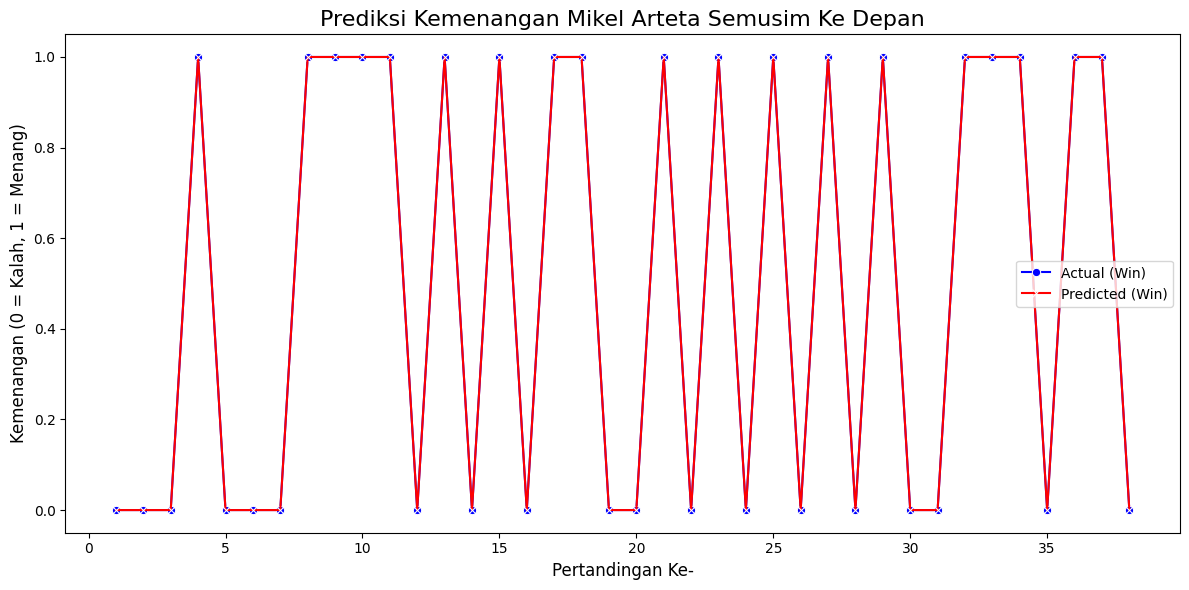

In [75]:
# Mengonversi hasil prediksi ke Pandas
predictions_pd = predictions.select("game_id", "is_win", "prediction").limit(38).toPandas()

# Menambahkan kolom urutan pertandingan
predictions_pd['pertandingan_ke'] = predictions_pd.index + 1

# Membuat plot
plt.figure(figsize=(12, 6))

# Plotting menggunakan seaborn
sns.lineplot(x="pertandingan_ke", y="is_win", data=predictions_pd, label="Actual (Win)", marker="o", color="blue")
sns.lineplot(x="pertandingan_ke", y="prediction", data=predictions_pd, label="Predicted (Win)", marker="x", color="red")


plt.title("Prediksi Kemenangan Mikel Arteta Semusim Ke Depan", fontsize=16)
plt.xlabel("Pertandingan Ke-", fontsize=12)
plt.ylabel("Kemenangan (0 = Kalah, 1 = Menang)", fontsize=12)

plt.legend()

plt.tight_layout()
plt.show()


In [96]:
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource
from bokeh.layouts import column
from bokeh.io import output_notebook


# Mengonversi hasil prediksi ke Pandas
predictions_pd = predictions.select("game_id", "is_win", "prediction").limit(38).toPandas()

# Menambahkan kolom urutan pertandingan
predictions_pd['pertandingan_ke'] = predictions_pd.index + 1

# Membuat ColumnDataSource dari data Pandas
source = ColumnDataSource(predictions_pd)

# Membuat plot menggunakan Bokeh
p = figure(title="Prediksi Kemenangan Mikel Arteta Semusim Ke Depan",
           x_axis_label="Pertandingan Ke-",
           y_axis_label="Kemenangan (0 = Kalah, 1 = Menang)",
           height=400, width=800)

# Plotting actual win (is_win) dengan warna biru
p.line('pertandingan_ke', 'is_win', source=source, legend_label="Actual (Win)", line_width=2, color="blue")

# Menambahkan marker untuk actual win (titik)
p.scatter('pertandingan_ke', 'is_win', source=source, size=6, color="blue", legend_label="Actual (Win)", fill_alpha=0.6)

# Plotting predicted win (prediction) dengan warna merah
p.line('pertandingan_ke', 'prediction', source=source, legend_label="Predicted (Win)", line_width=2, color="red")

# Menambahkan marker untuk predicted win (titik)
p.scatter('pertandingan_ke', 'prediction', source=source, size=6, color="red", legend_label="Predicted (Win)", fill_alpha=0.6)

# Menambahkan legenda
p.legend.location = "top_left"


# Menampilkan plot di Jupyter Notebook
output_notebook()
show(p)


#Melakukan Cek Akurasi Prediksi

In [70]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Evaluator untuk menghitung akurasi
evaluator = BinaryClassificationEvaluator(labelCol="is_win", rawPredictionCol="prediction")

# Menghitung akurasi
accuracy = evaluator.evaluate(predictions)
print(f"Akurasi Model untuk Prediksi Kemenangan: {accuracy * 100:.2f}%")

Akurasi Model untuk Prediksi Kemenangan: 100.00%
